In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

def cls_predictor(num_inputs,num_anchors,num_classes):
    return nn.Conv2d(num_inputs,num_anchors*(num_classes+1),kernel_size=3,padding=1)
    # 这里numinputs 是输入的通道数目   numclasses是总类别数 当然加1是因为背景  numanchors是每个像素下面生成的锚框数目
    #因为最后是要映射成一个像素，不使用线性层，因为太大，所以对于每一个像素点，都需要对其所有的锚框映射一个类别。

In [2]:
def bbox_predictor(num_inputs,num_anchors):
    return nn.Conv2d(num_inputs,num_anchors*4,kernel_size=3,padding=1)
    # 为每个bbox预测  bbox就是位置了 所以乘以了4  但其实记录不记录都可以  因为每一个bbox对应一个cls predictor

In [12]:
#除了批量大小这一维度外，其他三个维度都具有不同的尺寸。 为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。
def flatten_pred(pred):
    #print(torch.flatten(pred.permute(0,2,3,1),start_dim=1).shape)
    # 变换一下通道数  因为打平后像素是连续的。
    return torch.flatten(pred.permute(0,2,3,1),start_dim=1)

def concat_pred(preds):
    return torch.cat([flatten_pred(p) for p in preds],dim=1)
# 联系不同层之间的预测结果  好去算损失

In [13]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [14]:
concat_pred([Y1, Y2]).shape

torch.Size([2, 25300])

In [15]:
# 定义高宽减半块
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [16]:
# 定义基本的网络
def base_net():
    blk =[]
    num_filters = [3,16,32,64]
    for i in range(len(num_filters)-1):
        blk.append(down_sample_blk(num_filters[i],num_filters[i+1]))

    return nn.Sequential(*blk)


In [17]:
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [18]:
# 定义完整的模型 模型深度是5
def get_blk(i):
    if i==0:
        blk = base_net()
    elif i==1:
        blk = down_sample_blk(64,128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128,128)
    return blk
        

In [20]:
# 现在我们为每个块定义前向传播。与图像分类任务不同，此处的输出包括：CNN特征图Y；在当前尺度下根据Y生成的锚框；预测的这些锚框的类别和偏移量（基于Y）。
# 计算的基本单位是块，所以要定义一下块的前向传播
def blk_forward(X,blk,size,ratio,cls_predictor,bbox_predictor):
    Y = blk(X)
    #生成以每个像素为中心具有不同形状的锚框
    anchors = d2l.multibox_prior(Y,size,ratios=ratio)
    # 不传入锚框，为什么
    # 锚框是什么我不管  我传的就是fature map  只是在反向传播的时候需要关注具体的。
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [22]:
# 越往下越关注全局信息，  所以sizes也逐渐变大，来关注全局信息。
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [23]:
class TinySSD(nn.Module):
    def __init__(self,num_classes,**kwargs):
        super(TinySSD,self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64,128,128,128,128]
        # 这里的值对应网络结构那里

        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))
            
    def forward(self,X):
        anchors,cls_preds,bbox_preds = [None]*5, [None]*5, [None]*5
        for i in range(5):
            X,anchors[i],cls_preds[i],bbox_preds[i] = blk_forward(X,getattr(self,f"blk_{i}"),sizes[i],ratios[i],
                                                                  getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors,dim=1)
        cls_preds = concat_pred(cls_preds)
        # 设置成softmax需要的
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_pred(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [24]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [25]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

正在从http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip下载..\data\banana-detection.zip...
read 1000 training examples
read 100 validation examples


In [26]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [27]:
# 定义损失函数  主要是类别损失 使用softmax 还有一个是位置偏移损失
cls_loss = nn.CrossEntropyLoss(reduction="none")
bbox_loss = nn.L1Loss(reduction="none")

def clac_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks):
    batch_size,num_classes = cls_preds.shape[0],cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1,num_classes),cls_labels.reshape(-1)).reshape(batch_size,-1).mean(dim=1)
    bbox = bbox_loss(bbox_preds*bbox_masks,bbox_labels*bbox_masks).mean(dim=1)
    return cls+bbox

In [28]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.17e-03, bbox mae 3.02e-03
8983.2 examples/sec on cuda:0


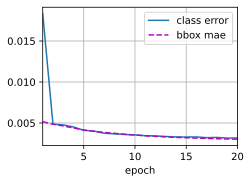

In [29]:
# 进行训练
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])

net = net.to(device)

for epoch in range(num_epochs):
    net.train()
    metric = d2l.Accumulator(4)
    for features,target in train_iter:
        timer.start()
        trainer.zero_grad()
        X,y = features.to(device),target.to(device)
        anchors,cls_preds,bbox_preds = net(X)
        # 获取到锚框 预测类别 和 预测的位置
        # 使用真实边界框标记锚框
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, y)
        # 这里真实传入了anchors  返回的是每个锚框对应的label  cls 和是否是背景
        # 计算损失值
        l = clac_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

In [30]:
# 预测目标
def predict(X):
    net.eval()
    anchors,cls_preds,bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds,dim=2).permute(0,2,1)
    output = d2l.multibox_detection(cls_probs,bbox_preds,anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

In [35]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')



In [32]:
X = torchvision.io.read_image(r'E:\VScodes\ipython\计算机视觉\目标检测\data\banana-detection\bananas_val\images\65.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [33]:
output = predict(X)

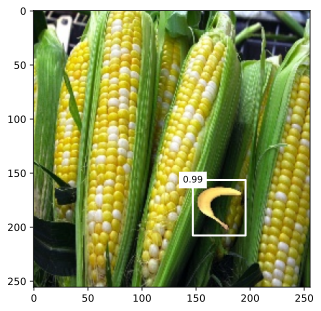

In [34]:
display(img, output.cpu(), threshold=0.9)